### Import Libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Visualize the dataset

Correctly Masked Face Dataset


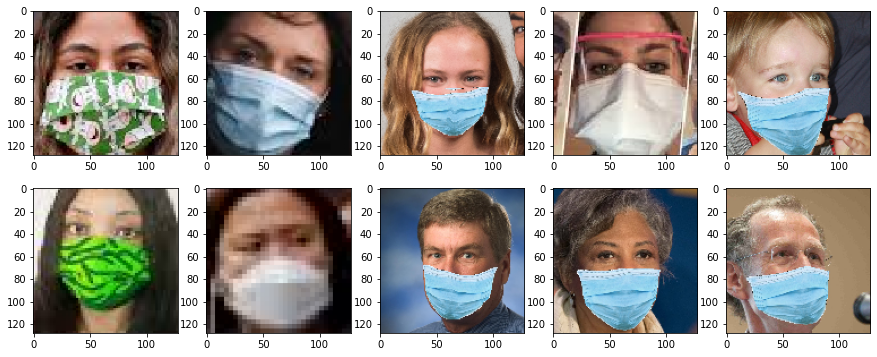

Incorrectly Masked Face Dataset


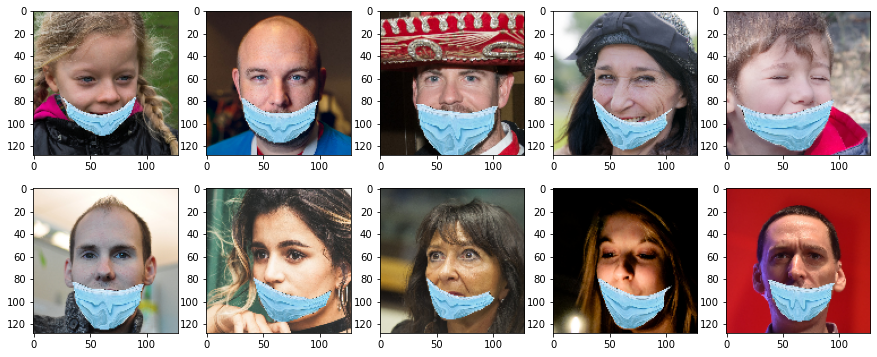

Without Masked Face Dataset


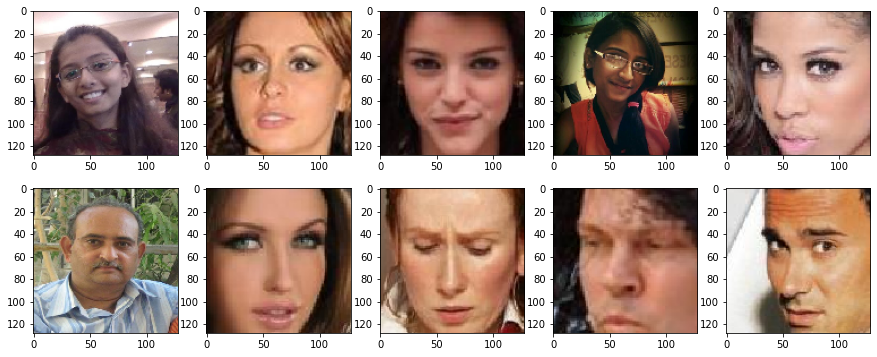

In [2]:
files = ['CMFD' , 'IMFD', 'WMFD']

names = {'CMFD': 'Correctly Masked Face Dataset', 
         'IMFD': 'Incorrectly Masked Face Dataset',
         'WMFD' : 'Without Masked Face Dataset'}

dir_ = os.path.join(os.getcwd(), 'Dataset')

for file in files:
    print(names[file])
    dir = os.path.join(dir_, file)
    images = os.listdir(dir)
    plt.figure(figsize=(15, 6))
    for i, img in enumerate(images[20:30]):
        image = load_img(os.path.join(dir, img), target_size=(128, 128))
        image = img_to_array(image) / 255
        plt.subplot(2,5,i+1)
        plt.imshow(image)
    plt.show()
    

### Resize Dataset

In [3]:
! python resize_dataset.py

Created resized dataset!


### Data augmentation

In [3]:
validation_split = 0.20

datagen = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    rotation_range=20,
    shear_range=0.15,
    horizontal_flip=True,
    validation_split=validation_split
)

train_generator = datagen.flow_from_directory(
    "dir", 
    target_size=(128, 128),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 32,
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    "dir",
    target_size=(128, 128),
    color_mode="rgb",
    class_mode='categorical',
    batch_size = 8,
    subset='validation'
)

Found 262 images belonging to 3 classes.
Found 65 images belonging to 3 classes.


### Transfer Learning

In [4]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [5]:
last_layer = base_model.layers[-1]
last_output = last_layer.output

In [6]:
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(128, activation = 'relu')(x)
x = keras.layers.Dense(3, activation = 'softmax')(x)

In [7]:
model = keras.Model(base_model.input, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [8]:
model.compile(optimizer = Adam(learning_rate = 1e-04 ),
              loss = 'categorical_crossentropy',  
              metrics = ['accuracy']
             )

In [9]:
history = model.fit( train_generator,
                     epochs = 10,
                     steps_per_epoch = train_generator.n // 32, 
                     validation_data = validation_generator,
                     verbose = 2,
                     validation_steps = validation_generator.n // 8
)

Epoch 1/10
8/8 - 21s - loss: 1.0577 - accuracy: 0.4652 - val_loss: 0.8263 - val_accuracy: 0.5625
Epoch 2/10
8/8 - 22s - loss: 0.7361 - accuracy: 0.7043 - val_loss: 0.5885 - val_accuracy: 0.7031
Epoch 3/10
8/8 - 26s - loss: 0.5943 - accuracy: 0.7773 - val_loss: 0.4702 - val_accuracy: 0.8438
Epoch 4/10
8/8 - 22s - loss: 0.4658 - accuracy: 0.8609 - val_loss: 0.3971 - val_accuracy: 0.8594
Epoch 5/10
8/8 - 27s - loss: 0.3981 - accuracy: 0.8957 - val_loss: 0.4720 - val_accuracy: 0.8125
Epoch 6/10
8/8 - 28s - loss: 0.3852 - accuracy: 0.8913 - val_loss: 0.3517 - val_accuracy: 0.8594
Epoch 7/10
8/8 - 28s - loss: 0.3287 - accuracy: 0.8906 - val_loss: 0.3951 - val_accuracy: 0.7969
Epoch 8/10
8/8 - 27s - loss: 0.3072 - accuracy: 0.9023 - val_loss: 0.3412 - val_accuracy: 0.8594
Epoch 9/10
8/8 - 28s - loss: 0.2338 - accuracy: 0.9348 - val_loss: 0.3559 - val_accuracy: 0.8438
Epoch 10/10
8/8 - 30s - loss: 0.2340 - accuracy: 0.9453 - val_loss: 0.2477 - val_accuracy: 0.9062


### Fine-Tuning

In [ ]:
base_model.trainable = True

model.compile(optimizer = Adam(learning_rate = 1e-05 ),
              loss = 'categorical_crossentropy',  
              metrics = ['accuracy']
             )

history = model.fit(   train_generator,
                       epochs = 10,
                       steps_per_epoch = train_generator.n // 32, 
                       validation_data = validation_generator,
                       verbose = 2,
                       validation_steps = validation_generator.n // 8
)